In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
import sys
sys.path.append('/global/u1/s/sfschen/Python/velocileptors/')

from velocileptors.LPT.lpt_rsd_fftw import LPT_RSD
from classy import Class

In [4]:
z = 0.61
omega_b = 0.02242
omega_c = 0.11933
lnAs =  3.047
h = 0.6766
ns = 0.9665

nnu = 1
nur = 2.033
mnu = 0.06037735849

fac = 1.0

pkparams = {
    'output': 'mPk',
    'P_k_max_h/Mpc': 20.,
    'z_pk': '0.0,10',
    'A_s': fac * np.exp(lnAs)*1e-10,
    'n_s': ns,
    'h': h,
    'N_ur': nur,
    'N_ncdm': nnu,
    'm_ncdm': mnu,
    'tau_reio': 0.0568,
    'omega_b': omega_b,
    'omega_cdm': omega_c}

import time
t1 = time.time()
pkclass = Class()
pkclass.set(pkparams)
pkclass.compute()

speed_of_light = 2.99792458e5
Hz = pkclass.Hubble(z) * speed_of_light / h # this H(z) in units km/s/(Mpc/h) = 100 * E(z)
chiz = pkclass.angular_distance(z) * (1.+z) * h # this is the comoving radius in units of Mpc/h 

fnu = pkclass.Omega_nu/pkclass.Omega_m()
f = pkclass.scale_independent_growth_factor_f(z) * (1 - 0.6*fnu)

ki = np.logspace(-3.0,1.0,200)
pi = np.array( [pkclass.pk_cb(k*h, z ) * h**3 for k in ki] )

In [5]:
sigma8 = pkclass.sigma8()

In [6]:
sigma8

0.8099301616589367

In [7]:
# Reference Cosmology:
Omega_M = 0.31
fb = 0.1571


pkparams = {
    'output': 'mPk',
    'P_k_max_h/Mpc': 20.,
    'z_pk': '0.0,10',
    'A_s': np.exp(3.040)*1e-10,
    'n_s': ns,
    'h': h,
    'N_ur': 3.046,
    'N_ncdm': 0,#1,
    #'m_ncdm': 0,
    'tau_reio': 0.0568,
    'omega_b': h**2 * fb * Omega_M,
    'omega_cdm': h**2 * (1-fb) * Omega_M}

import time
t1 = time.time()
pkclass = Class()
pkclass.set(pkparams)
pkclass.compute()

Hz_fid = pkclass.Hubble(z) * speed_of_light / h # this H(z) in units km/s/(Mpc/h) = 100 * E(z)
chiz_fid = pkclass.angular_distance(z) * (1.+z) * h # this is the comoving radius in units of Mpc/h 

In [8]:
apar, aperp = Hz_fid / Hz, chiz / chiz_fid

In [9]:
# Now make the PT object:
modPT = LPT_RSD(ki, pi, kIR=0.2,\
                cutoff=10, extrap_min = -4, extrap_max = 3, N = 2000, threads=1, jn=5)
modPT.make_pltable(f, kmin=1e-3, kmax=0.5, nk = 200, apar=apar, aperp=aperp, ngauss=4)

0

In [10]:
# Now set up the power spectrum model
from scipy.interpolate import InterpolatedUnivariateSpline as Spline

kth = np.arange(0, 0.4, 0.001)
kth_c = kth + 0.001/2

kobs = np.arange(0,0.4,0.01)
kobs_c = kobs + 0.01/2

def pkell(pars):
    
    b1, b2, bs, alpha0, alpha2, sn2 = pars
    b3 = 0
    sn0 = 0
    alpha4 = 0
    sn4 = 0
    
    bvec = [b1,b2,bs,b3,alpha0,alpha2,alpha4,0,1e3*sn0,1e3*sn2,1e3*sn4]
        
    kv, p0, p2, p4 = modPT.combine_bias_terms_pkell(bvec)
    
    p0th, p2th, p4th = Spline(kv,p0,ext=3)(kth_c), Spline(kv,p2,ext=3)(kth_c), Spline(kv,p4,ext=3)(kth_c)
    
    return p0th, p2th, p4th

In [11]:
# Load matrices and such things:
from pktools import*

filename = '../boss_data_renorm/pk/ps1D_BOSS_DR12_NGC_z3_COMPnbar_TSC_700_700_700_400_renorm.dat'
dats = read_power(filename)

In [12]:
dats['sig0']

masked_array(data=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False],
       fill_value=1e+20)

(0.0, 0.2)

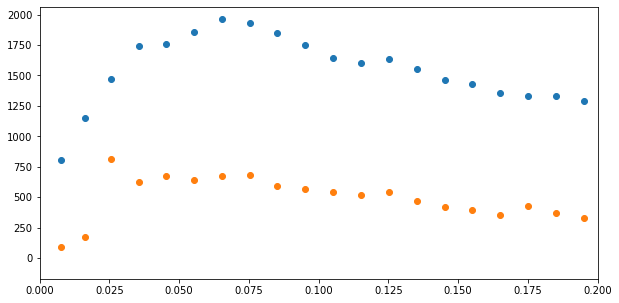

In [13]:
plt.figure(figsize=(10,5))

kdat = dats['k_center']
p0dat = dats['pk0']
err0 = dats['sig0']

p2dat = dats['pk2']
err2 = dats['sig2']

plt.errorbar(kdat, kdat * p0dat, yerr=kdat * err0, fmt='o')
plt.errorbar(kdat, kdat * p2dat, yerr=kdat * err2, fmt='o')

plt.xlim(0,0.2)

In [14]:
M = np.loadtxt('../boss_data_renorm/matrices/M_BOSS_DR12_NGC_z3_V6C_1_1_1_1_1_1200_2000.matrix.gz')
W = np.loadtxt('../boss_data_renorm/matrices/W_BOSS_DR12_NGC_z3_V6C_1_1_1_1_1_10_200_2000_averaged_v1.matrix.gz')

In [15]:
# Now define function with the whole thing:
def pkobs(bvec):
    
    p0th, p2th, p4th = pkell(bvec)
    pk_model_vector = np.concatenate((p0th,p2th,p4th))
    
    # wide angle
    expanded_model = np.matmul(M, pk_model_vector )
    # Convolve with window (true) −> (conv) see eq. 2.18
    convolved_model = np.matmul(W, expanded_model )
    
    return convolved_model

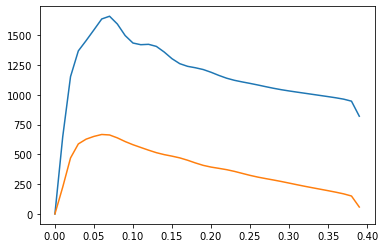

In [16]:
# Trial run:
thy = pkobs([1,0,0,0,0,0])
p0thy = thy[:40]
p2thy = thy[80:120]

plt.plot(kobs, kobs * p0thy)
plt.plot(kobs, kobs * p2thy)

In [17]:
# Now set up the covariance
cov = np.loadtxt('../boss_data_renorm/covariances/C_2048_BOSS_DR12_NGC_z3_V6C_1_1_1_1_1_10_200_200_prerecon.matrix.gz')

In [18]:
err0 = np.diag(cov)[:40]**0.5
err2 = np.diag(cov)[80:120]**0.5

In [19]:
# Set the fit ranges
kbins, pkvec = dict_to_vec(dats)

krange = (kobs_c > 0.02) * (kobs_c < 0.2)

kexcl  = kobs_c < 0
fit_range = np.concatenate( (krange, kexcl, krange, kexcl, kexcl))

fit_data = pkvec[fit_range]

Cinv = np.linalg.inv( cov[np.ix_(fit_range, fit_range)] )

<ipython-input-20-a987f73eb166>:1: RuntimeWarning: invalid value encountered in log
  plt.imshow( np.log(np.linalg.inv(Cinv)) )


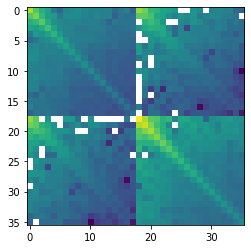

In [20]:
plt.imshow( np.log(np.linalg.inv(Cinv)) )

In [21]:
def chi2(bvec):
    
    thy = pkobs(bvec)[fit_range]
    diff = thy - fit_data
    
    return np.dot(diff ,np.dot(Cinv ,diff ))

In [22]:
def diff_pk(bvec):
    
    thy = pkobs(bvec)[fit_range]
    diff = thy - fit_data
    
    return diff

In [32]:
err0

array([12341.41369438,  5889.40859483,  3208.97020704,  1853.17814569,
        1228.88802488,   857.24189181,   642.03214301,   491.62210508,
         392.46845147,   303.96810548,   247.41295646,   213.16298551,
         180.15314499,   157.48859573,   137.99516154,   119.80167777,
         109.61815509,    99.54732827,    89.88883785,    82.06057772,
          78.00484784,    69.16164694,    63.97549603,    59.94471175,
          56.04553939,    52.43130684,    49.71388211,    45.81913088,
          43.5405108 ,    41.36035358,    39.18250846,    37.4682843 ,
          35.71146449,    36.17899932,    33.81756492,    32.4130445 ,
          31.43270269,    29.64473883,    27.71151728,    27.43502584])

(0.0, 0.2)

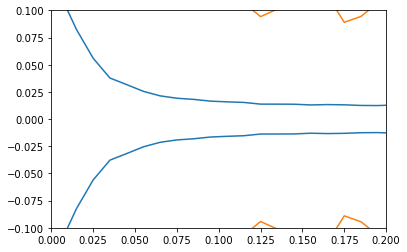

In [31]:
plt.plot(kobs_c, err0/p0dat, c='C0')
plt.plot(kobs_c, -err0/p0dat, c='C0')
plt.plot(kobs_c, err2/p2dat, c='C1')
plt.plot(kobs_c, -err2/p2dat, c='C1')

plt.ylim(-0.1,0.1)
plt.xlim(0,0.2)

(200.0, 400.0)

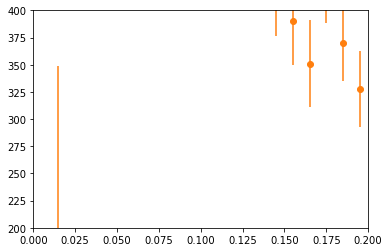

In [29]:
plt.errorbar(kobs_c, kobs_c * p2dat, yerr= kobs_c * err2, fmt='o', c='C1')
plt.xlim(0,0.2)
plt.ylim(200,400)

In [36]:
# optimize
from scipy.optimize import minimize

res = minimize(chi2, [1,0,0,0,0,0] )

(-100.0, 2200.0)

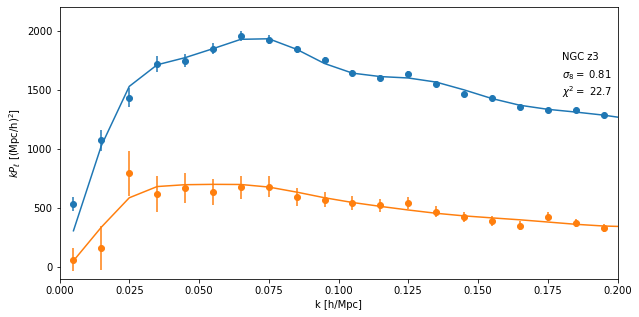

In [37]:
plt.figure(figsize=(10,5))
thy = pkobs(res.x)

p0thy = thy[0:40]
p2thy = thy[80:120]

plt.plot(kobs_c, kobs_c * p0thy)
plt.plot(kobs_c, kobs_c * p2thy)

plt.errorbar(kobs_c, kobs_c * p0dat, yerr=kobs_c * err0, fmt='o', c='C0')
plt.errorbar(kobs_c, kobs_c * p2dat, yerr= kobs_c * err2, fmt='o', c='C1')

plt.text(0.18, 1750, 'NGC z3')
plt.text(0.18, 1600, r'$\sigma_8 = $ %.2f' %(sigma8))
plt.text(0.18, 1450, r'$\chi^2 = $ %.1f' %(res.fun))

plt.xlabel('k [h/Mpc]')
plt.ylabel(r'$k P_\ell$ [(Mpc/h)$^2$]')

plt.xlim(0,0.2)
plt.ylim(-100,2200)

(-200.0, 200.0)

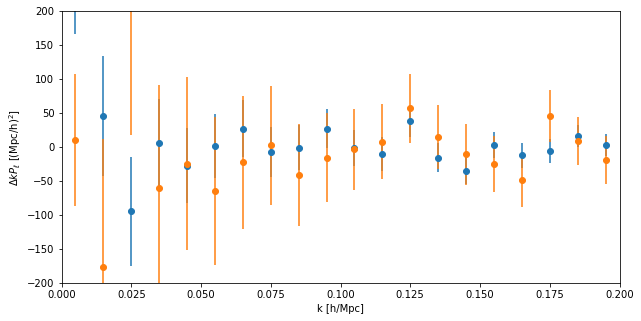

In [38]:
plt.figure(figsize=(10,5))
thy = pkobs(res.x)

p0thy = thy[0:40]
p2thy = thy[80:120]

#plt.plot(kobs_c, kobs_c * p0thy)
#plt.plot(kobs_c, kobs_c * p2thy)

plt.errorbar(kobs_c, kobs_c * (p0dat - p0thy), yerr=kobs_c * err0, fmt='o', c='C0')
plt.errorbar(kobs_c, kobs_c * (p2dat - p2thy), yerr= kobs_c * err2, fmt='o', c='C1')

#plt.text(0.18, 1750, 'NGC z3')
#plt.text(0.18, 1600, r'$\sigma_8 = $ %.2f' %(sigma8))
#plt.text(0.18, 1450, r'$\chi^2 = $ %.1f' %(res.fun))

plt.xlabel('k [h/Mpc]')
plt.ylabel(r'$ \Delta k P_\ell$ [(Mpc/h)$^2$]')

plt.xlim(0,0.2)
plt.ylim(-200,200)

In [39]:
# Look at a bunch of values of sigma8:
facs = [0.6, 0.8, 1.0, 1.2]
#facs = np.arange(0.6, 1.2, 0.025)
    
chi2s = []
p0ths = []
p2ths = []

for fac in facs:
    
    print(fac)
    kvec = np.concatenate( ([0.0005,], np.logspace(np.log10(0.0015),np.log10(0.025),10, endpoint=True), np.arange(0.03,0.51,0.01)) )

    
    modPT = LPT_RSD(ki, fac * pi, kIR=0.2,\
                cutoff=10, extrap_min = -4, extrap_max = 3, N = 2000, threads=1, jn=5)
    #modPT.make_pltable(f, kmin=1e-3, kmax=0.5, nk = 200, apar=apar, aperp=aperp, ngauss=4)
    modPT.make_pltable(f, kv=kvec, apar=apar, aperp=aperp, ngauss=4)
    
    res = minimize(chi2, [1,0,0,0,0,0], options={'gtol': 1e-08,} )
    print(res.x)
    
    thy = pkobs(res.x)
    p0ths += [thy[0:40], ]
    p2ths += [thy[80:120], ]
    chi2s += [res.fun]
    

0.6
[  1.70504014  -3.91965668   1.23120219  22.61564747   6.98448465
 -27.29099065]
0.8
[ 1.28727185 -3.32143156  0.54694377  9.56876991  5.51309532 -2.1955784 ]
1.0
[ 0.99580521 -2.77410029  0.08297331  2.27619229  7.5189624  18.43770158]
1.2
[ 0.7763532  -2.33349559 -0.23486886 -2.40248123 11.91156105 34.99751377]


0.8099301616589367
0.8099301616589367
0.8099301616589367
0.8099301616589367


(-100.0, 2000.0)

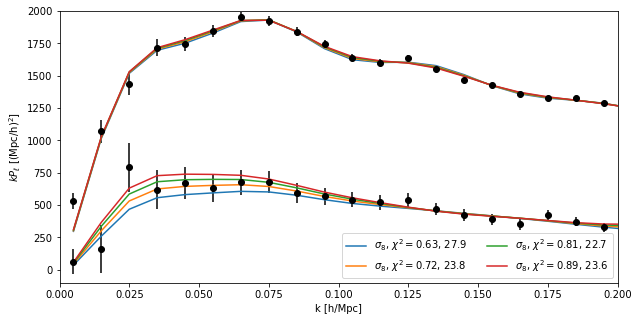

In [40]:
plt.figure(figsize=(10,5))
thy = pkobs(res.x)

p0thy = thy[0:40]
p2thy = thy[80:120]

for ii, fac in enumerate(facs):
    print(sigma8)
    plt.plot(kobs_c, kobs_c * p0ths[ii], 'C'+str(ii), label=r'$\sigma_8,\, \chi^2 = $%.2f, %.1f' %(sigma8*np.sqrt(fac),chi2s[ii]))
    plt.plot(kobs_c, kobs_c * p2ths[ii], 'C'+str(ii))

plt.errorbar(kobs_c, kobs_c * p0dat, yerr=kobs_c * err0, fmt='o', c='k')
plt.errorbar(kobs_c, kobs_c * p2dat, yerr= kobs_c * err2, fmt='o', c='k')

#plt.text(0.18, 1750, 'NGC z3')
#plt.text(0.18, 1600, r'$\sigma_8 = $ %.2f' %(sigma8))
#plt.text(0.18, 1450, r'$\chi^2 = $ %.1f' %(res.fun))

plt.xlabel('k [h/Mpc]')
plt.ylabel(r'$k P_\ell$ [(Mpc/h)$^2$]')
plt.legend(ncol=2)

plt.xlim(0,0.2)
plt.ylim(-100,2000)

(-20.0, 20.0)

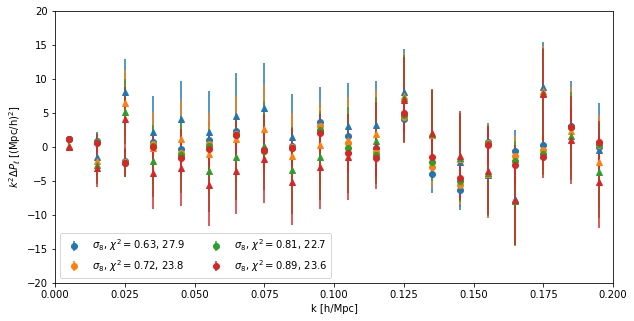

In [41]:
plt.figure(figsize=(10,5))
thy = pkobs(res.x)

p0thy = thy[0:40]
p2thy = thy[80:120]

for ii, fac in enumerate(facs):
    #plt.plot(kobs_c, kobs_c * p0ths[ii], 'C'+str(ii), label=r'$\sigma_8,\, \chi^2 = $%.2f, %.1f' %(sigma8*np.sqrt(fac),chi2s[ii]))
    #plt.plot(kobs_c, kobs_c * p2ths[ii], 'C'+str(ii))

    plt.errorbar(kobs_c, kobs_c**2 * (p0dat - p0ths[ii]), yerr=kobs_c**2 * err0, fmt='o', c='C'+str(ii), label=r'$\sigma_8,\, \chi^2 = $%.2f, %.1f' %(sigma8*np.sqrt(fac),chi2s[ii]))
    plt.errorbar(kobs_c, kobs_c**2 * (p2dat - p2ths[ii]), yerr= kobs_c**2 * err2, fmt='^', c='C'+str(ii))

#plt.text(0.18, 1750, 'NGC z3')
#plt.text(0.18, 1600, r'$\sigma_8 = $ %.2f' %(sigma8))
#plt.text(0.18, 1450, r'$\chi^2 = $ %.1f' %(res.fun))

plt.xlabel('k [h/Mpc]')
plt.ylabel(r'$k^2 \Delta P_\ell$ [(Mpc/h)$^2$]')
plt.legend(loc='lower left', ncol=2)

plt.xlim(0,0.2)
plt.ylim(-20,20)

In [76]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 10

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

0.8099301616589367
0.8099301616589367
0.8099301616589367
0.8099301616589367


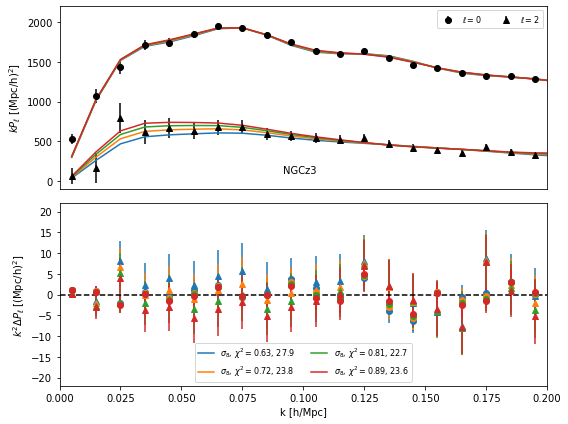

In [77]:
# Joint Plot

fig = plt.figure(figsize=(8,6))

plt.subplot(2,1,1)

for ii, fac in enumerate(facs):
    print(sigma8)
    plt.plot(kobs_c, kobs_c * p0ths[ii], 'C'+str(ii), )
    plt.plot(kobs_c, kobs_c * p2ths[ii], 'C'+str(ii))

plt.errorbar(kobs_c, kobs_c * p0dat, yerr=kobs_c * err0, fmt='o', c='k', label=r'$\ell = 0$')
plt.errorbar(kobs_c, kobs_c * p2dat, yerr= kobs_c * err2, fmt='^', c='k', label=r'$\ell = 2$')

#plt.text(0.18, 1750, 'NGC z3')
#plt.text(0.18, 1600, r'$\sigma_8 = $ %.2f' %(sigma8))
#plt.text(0.18, 1450, r'$\chi^2 = $ %.1f' %(res.fun))

#plt.xlabel('k [h/Mpc]')
plt.ylabel(r'$k P_\ell$ [(Mpc/h)$^2$]')
plt.legend(loc='upper right',ncol=3)

plt.xlim(0,0.2)
plt.ylim(-100,2200)
plt.text(0.0915, 100, 'NGCz3')
plt.xticks([])

plt.subplot(2,1,2)

for ii, fac in enumerate(facs):
    #plt.plot(kobs_c, kobs_c * p0ths[ii], 'C'+str(ii), label=r'$\sigma_8,\, \chi^2 = $%.2f, %.1f' %(sigma8*np.sqrt(fac),chi2s[ii]))
    #plt.plot(kobs_c, kobs_c * p2ths[ii], 'C'+str(ii))

    plt.errorbar(kobs_c, kobs_c**2 * (p0dat - p0ths[ii]), yerr=kobs_c**2 * err0, fmt='o', c='C'+str(ii))
    plt.errorbar(kobs_c, kobs_c**2 * (p2dat - p2ths[ii]), yerr= kobs_c**2 * err2, fmt='^', c='C'+str(ii))
    plt.plot(-1000,1000, 'C'+str(ii), label=r'$\sigma_8,\, \chi^2 = $%.2f, %.1f' %(sigma8*np.sqrt(fac),chi2s[ii]))
    
#plt.text(0.18, 1750, 'NGC z3')
#plt.text(0.18, 1600, r'$\sigma_8 = $ %.2f' %(sigma8))
#plt.text(0.18, 1450, r'$\chi^2 = $ %.1f' %(res.fun))

plt.plot([0,1],[0,0],'k--')

plt.xlabel('k [h/Mpc]')
plt.ylabel(r'$k^2 \Delta P_\ell$ [(Mpc/h)$^2$]')
#plt.legend(loc='lower left', ncol=2)
plt.legend(loc='lower center', ncol=2)

plt.xlim(0,0.2)
plt.ylim(-22,22)
plt.tight_layout()

plt.savefig('Figures/sigma8_scan_planck_lcdm_ngc_z3.pdf')

AttributeError: 'Figure' object has no attribute 'fontsize'

In [ ]:
plt.plot(facs**0.5 * sigma8, chi2s, 'o-')

In [ ]:
chi2(res.x)

In [ ]:
chi2(res.x)

In [ ]:
a, b, c = pkell(res.x)

In [ ]:
d, e, g = pkell(res.x)

In [ ]:
plt.semilogx(kth_c, b/e-1, '.')
plt.ylim(-0.01,0.01)

In [ ]:
t2-t1

In [ ]:
# Testing for number of k bins in modPT
# Now make th
#make PT object:
import time
t1 = time.time()
modPT = LPT_RSD(ki, pi, kIR=0.2,\
                cutoff=10, extrap_min = -4, extrap_max = 3, N = 2000, threads=1, jn=5)
modPT.make_pltable(f, kmin=1e-3, kmax=0.5, nk = 200, apar=apar, aperp=aperp, ngauss=4)
#modPT.make_pltable(f, kv=kth_c, apar=apar, aperp=aperp, ngauss=4)
t2 = time.time()
print(t2-t1)

In [ ]:
#  Leaner
#kvec = np.concatenate( (np.logspace(-3,np.log10(0.025),10, endpoint=True), np.arange(0.03,0.45,0.01)) )
t1 = time.time()
modPT = LPT_RSD(ki, pi, kIR=0.2,\
                cutoff=10, extrap_min = -4, extrap_max = 3, N = 2000, threads=1, jn=5)
modPT.make_pltable(f, kv=kvec, apar=apar, aperp=aperp, ngauss=4)
t2 =time.time()
print(t2-t1)

In [ ]:
kvec.shape

In [ ]:
def pkell(pars,PT):
    
    b1, b2, bs, alpha0, alpha2, sn2 = pars
    b3 = 0
    sn0 = 0
    alpha4 = 0
    sn4 = 0
    
    bvec = [b1,b2,bs,b3,alpha0,alpha2,alpha4,0,1e3*sn0,1e3*sn2,1e3*sn4]
        
    kv, p0, p2, p4 = PT.combine_bias_terms_pkell(bvec)
    
    p0th, p2th, p4th = Spline(kv,p0,ext=3)(kth_c), Spline(kv,p2,ext=3)(kth_c), Spline(kv,p4,ext=3)(kth_c)
    
    return p0th, p2th, p4th

In [ ]:
p0fid, p2fid, p4fid = pkell(res.x, modPT)
p01, p21, p41 = pkell(res.x, modPT1)

In [ ]:
plt.plot(kth_c, p2fid/p21-1)

plt.ylim(-0.01,0.01)

In [ ]:
#kv = np.logspace(-3,np.log10(0.5),50)
kvec = np.concatenate( ([0.0005,], np.logspace(np.log10(0.0015),np.log10(0.025),10, endpoint=True), np.arange(0.03,0.51,0.01)) )
plt.plot(kvec, kvec * np.interp(kvec, ki,pi), '.')

In [ ]:
np.arange(0.06,0.5,0.01).shape


In [ ]:
kvec.shape